<a href="https://colab.research.google.com/github/BrendaLoznik/titanic/blob/main/Titanic_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Titanic!!

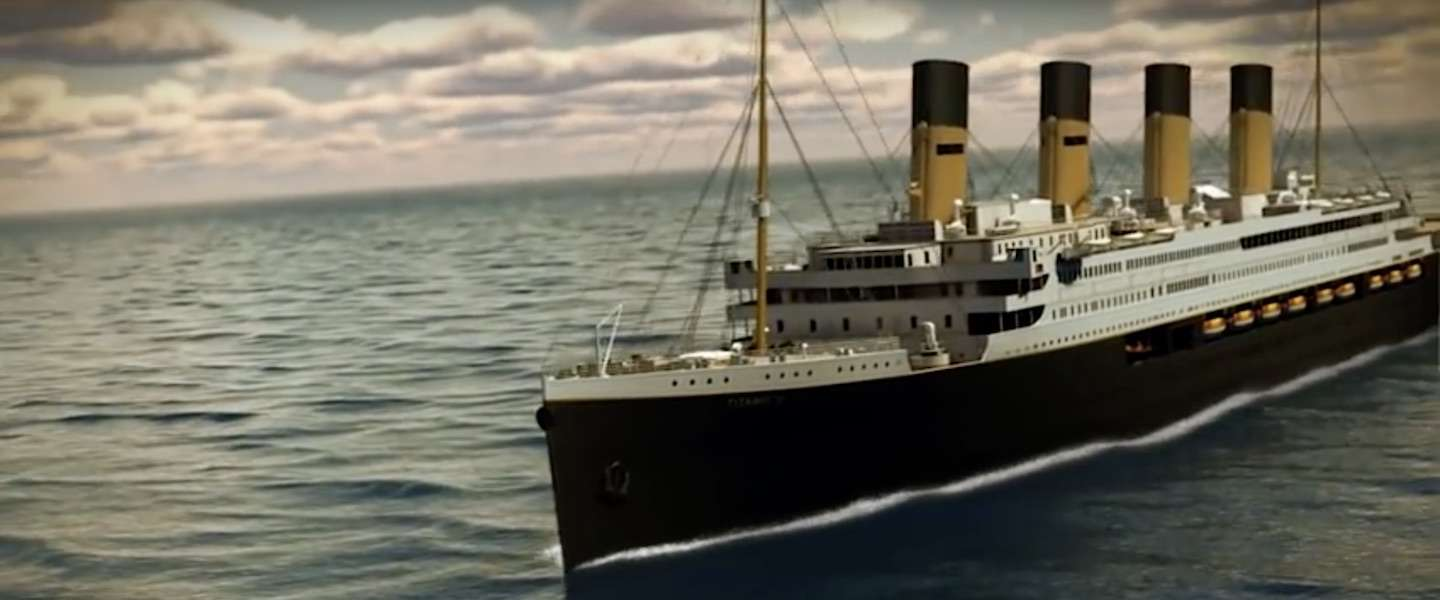

Who hasn’t seen or heard off the world-famous Titanic! The sinking of the Titanic is one of the most famous shipwrecks in history and one of the highest grossing movies of all time. 




Who would have thought it also the topic of one of the most popular Machine Learning competitions on Kaggle?! Over 19.000 teams and individuals have tried their luck on successfully predicting the fate of the passengers onboard of this unsinkable ship. 




In this Notebook I will show you how I got a top 9% score on the Leaderboard.





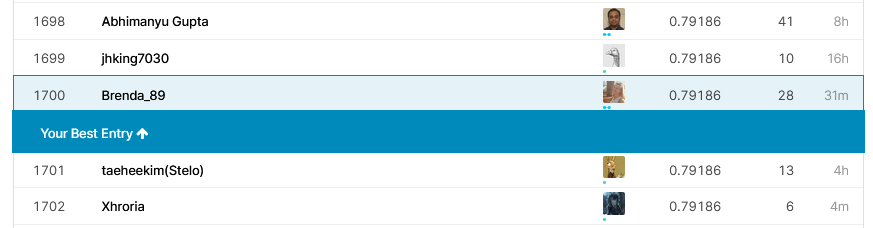

##**1 HOUSEKEEPING**

####**1.1 LOADING LIBRARIES**

In [ ]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#feature engineering
import re
from sklearn.preprocessing import StandardScaler

#modelling
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

####**1.2 LOADING DATA**

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train=pd.read_csv('/content/gdrive/My Drive/Kaggle/Titanic/train.csv')
test=pd.read_csv('/content/gdrive/My Drive/Kaggle/Titanic/test.csv')

##**2 CLEANING**

I like to concatenate the training and testing data together for cleaning and exploratory data analysis. We have to be careful in order to prevent data leakage.

In [ ]:
# Concatenate training and testing data together.
raw = pd.concat([train, test])
raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# The dataset consists of a mixture of numerical and non-numerical features
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


The dataset has 1.309 rows and 12 different features.
I will be easier to clean and analyze these features when I first divide them in different categories.

* Nominal: Categorical features without order
* Ordinal: Categorical features with order
* Binary: Categorical features with two possible outcomes
* Discrete: Numerical features that take discrete values
* Continuous: Numerical features consisting of continuous values

In [ ]:
#define feature categories
nominal = ['Name', 'Ticket', 'Embarked']
ordinal =  ['Cabin']
binary = ['Survived', 'Sex']
discrete = ['PassengerId', 'Pclass', 'SibSp', 'Parch' ]
continious = ['Age', 'Fare' ]

In [ ]:
print("Number of nominal features: {}".format(len(nominal)))
print("Number of ordinal features: {}".format(len(ordinal)))
print("Number of discrete features: {}".format(len(discrete)))
print("Number of continious features: {}".format(len(continious)))
print("Number of binary features: {}".format(len(binary)))
print("Total number offeatures: {}".format(len(continious + discrete + ordinal + nominal + binary)))

Number of nominal features: 3
Number of ordinal features: 1
Number of discrete features: 4
Number of continious features: 2
Number of binary features: 2
Total number offeatures: 12


I generally like to make a copy of the dataset for each phase of the project. This makes it easier to make changes.

In [ ]:
cleaned = raw.copy()

####**2.1 CONTINUOUS  FEATURES**

In [ ]:
# number of missing continious data
print(raw[continious].isna().sum().sort_values(ascending=False))

Age     263
Fare      1
dtype: int64


**2.1.1 AGE**

We don't know the age of 263 passengers. Let's figure out the best way to impute these missing ages.

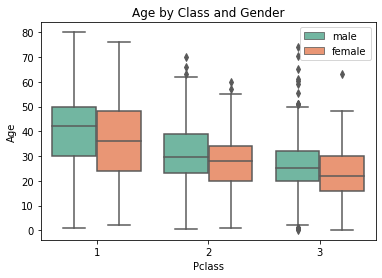

In [ ]:
# Older people travel in higher classes: Class and Gender are a factor
plt.figure(figsize=(6,4))
ax =sns.boxplot(x= "Pclass", y = "Age", data = raw, hue = "Sex", palette = 'Set2')
ax.set(title = 'Age by Class and Gender')
plt.legend(loc= "upper right")
plt.show()

In [ ]:
#extract title with regex
cleaned["Title"] = cleaned["Name"].apply(lambda x: re.search('([A-Z][a-z]+)\.', x).group(1))

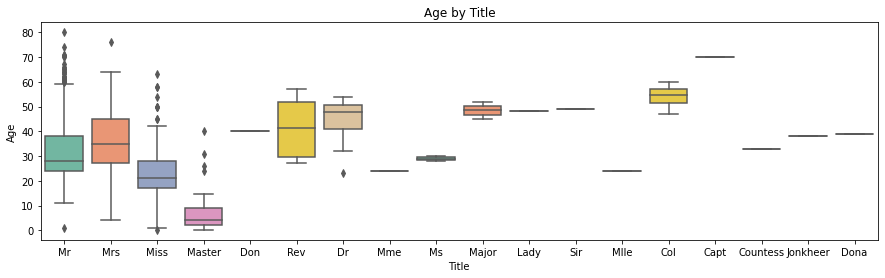

In [ ]:
# Ages differ quite drastically within genders
plt.figure(figsize=(15,4))
ax =sns.boxplot(x= "Title", y = "Age", data = cleaned, palette = 'Set2')
ax.set(title = 'Age by Title')
plt.show()

In [ ]:
#split the training and testing data before imputing
cleaned_train = cleaned[cleaned["PassengerId"].isin(train["PassengerId"])]i
cleaned_test =  cleaned[cleaned["PassengerId"].isin(test["PassengerId"])]

In [ ]:
#impute missing ages with the median age per class and title
cleaned_train["Age"] = cleaned_train["Age"].fillna(cleaned_train.groupby(["Pclass", "Title"])["Age"].transform("median"))
cleaned_test["Age"] = cleaned_test["Age"].fillna(cleaned_train.groupby(["Pclass", "Title"])["Age"].transform("median"))

**2.1.2 FARE**

In [ ]:
# We don't know the fare paid by a single third class passenger
missing = raw[raw["Fare"].isna()]
missing

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [ ]:
#check the median and mean Fare per class and title (only of training data to avoid leakage)
median = cleaned_train.groupby(["Pclass", "Title"])["Fare"].median()
mean = cleaned_train.groupby(["Pclass", "Title"])["Fare"].mean()
fare = pd.concat([median, mean], axis=1, keys = ["Median Fare", "Mean Fare"])
fare

Median Fare   Mean Fare
Pclass Title                            
1      Capt         71.00000   71.000000
       Col          31.02500   31.025000
       Countess     86.50000   86.500000
       Don          27.72080   27.720800
       Dr           39.60000   63.935840
       Jonkheer      0.00000    0.000000
       Lady         39.60000   39.600000
       Major        28.52500   28.525000
       Master      120.00000  117.802767
       Miss         91.75000  124.402715
       Mlle         59.40210   59.402100
       Mme          69.30000   69.300000
       Mr           42.40000   68.034385
       Mrs          79.42500   93.170636
       Sir          56.92920   56.929200
2      Dr           12.25000   12.250000
       Master       26.00000   27.306022
       Miss         13.00000   20.393750
       Mr           13.00000   19.252564
       Mrs          26.00000   23.496139
       Ms           13.00000   13.000000
       Rev          13.00000   18.312500
3      Master       28.51250   28.177232
       Miss          8.75625   15.248043
       Mr            7.89580   11.299762
       Mrs          15.97500   18.233529

In [ ]:
#impute missing fares by median age per class and title
cleaned_train["Fare"] = cleaned_train["Fare"].fillna(cleaned_train.groupby(["Pclass", "Title"])["Fare"].transform("median"))
cleaned_test["Fare"] = cleaned_test["Fare"].fillna(cleaned_train.groupby(["Pclass", "Title"])["Age"].transform("median"))

####**2.2 BINARY FEATURES**

In [ ]:
# We have no missing binary data to impute
print(raw[binary].isna().sum().sort_values(ascending=False))

Survived    418
Sex           0
dtype: int64


####**2.3 DISCRETE FEATURES**

In [ ]:
# Perfect, no missing data!
print(raw[discrete].isna().sum().sort_values(ascending=False))

Parch          0
SibSp          0
Pclass         0
PassengerId    0
dtype: int64


####**2.4 NOMINAL FEATURES**

In [ ]:
# number of missing nominal data: 
print(raw[nominal].isna().sum().sort_values(ascending=False))

Embarked    2
Ticket      0
Name        0
dtype: int64


In [ ]:
# We don't know where two adult female first class passengers boarded the Titanic
missing = raw[raw["Embarked"].isna()]
missing

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


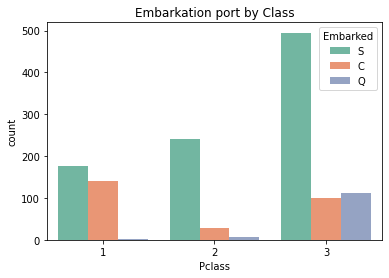

In [ ]:
#Most first class passengers boarded in Southampton
ax = sns.countplot(x="Pclass", hue="Embarked", data=raw, palette = 'Set2')
ax.set(title = "Embarkation port by Class")
plt.show()

In [ ]:
#impute missing values by Southampton
cleaned_train["Embarked"].fillna(value = "S", inplace = True)
cleaned_test["Embarked"].fillna(value = "S", inplace = True)

####**2.5 ORDINAL FEATURES**

Note: I think Cabin is a discrete feature because it indicates the Deck the passenger was on. My hypothesis is that people on higher decks had a greater chance of survival. We will check later whether my assumption was correct.

In [ ]:
# The cabin of a lot of passengers is missing
print(raw[ordinal].isna().sum().sort_values(ascending=False))

Cabin    1014
dtype: int64


In [ ]:
#impute missing cabin numbers by unknown
cleaned_train["Cabin"].fillna(value = "U", inplace = True)
cleaned_test["Cabin"].fillna(value = "U", inplace = True)

In [ ]:
# After imputing we can put the training and testing data back together
cleaned = pd.concat([cleaned_train, cleaned_test])
#cleaned.to_csv("cleaned2.csv")

In [ ]:
# Double-check if there is no more missing data
print(cleaned.isna().sum().sort_values(ascending=False))

Survived       418
Title            0
Embarked         0
Cabin            0
Fare             0
Ticket           0
Parch            0
SibSp            0
Age              0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64


## 3 E.D.A & FEATURE ENGINEERING

Now the fun part starts. Let's see what we can find! Before we continue, I will make a copy of the cleaned version of the dataset.

In [ ]:
#We can get a first glimpse of the characteristics of survival by plotting a simple pivot table
pd.pivot_table(cleaned, index = "Survived", values = ["Age", "SibSp", "Parch", "Fare"])

,Age,Fare,Parch,SibSp
Survived,,,,
0.0,29.799636,22.117887,0.329690,0.553734
1.0,28.098450,48.395408,0.464912,0.473684


In [ ]:
engineered = cleaned.copy()

####**3.1 CONTINUOUS FEATURES**

**3.1.1 AGE**

In [ ]:
#Visualizing the Age feature will be easier if we turn it from a float to an integer
engineered["Age"] = cleaned["Age"].astype("int")

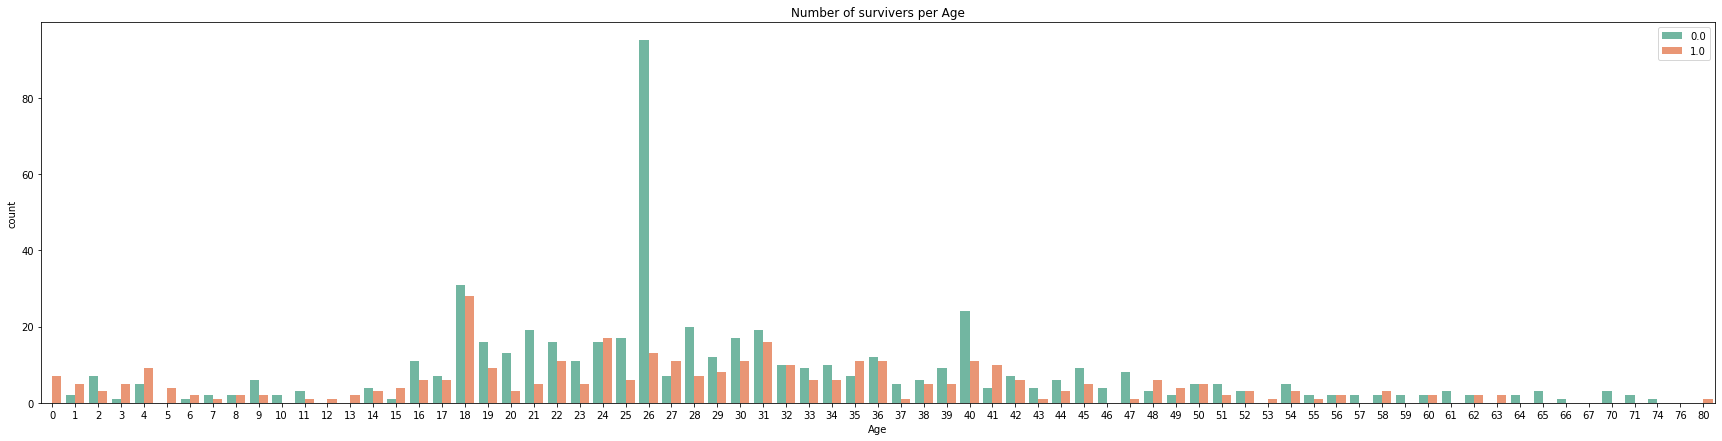

In [ ]:
# It looks like young people had a much better chance of survival than people in their twenties and thirties.
fig, ax = plt.subplots(figsize=(30,7))  
sns.countplot(x="Age", data=engineered, hue = "Survived", palette = "Set2")
ax.set(title = 'Number of survivers per Age')
plt.legend(loc= "upper right")
plt.show()

We can see that most passengers were in their early twenties until late thirties. There weren't many children on board, but we know they were favored during evacuation. We can speculate that older passengers had a lower chance of survival.

I want to create a feature binning the ages of passenger. I hope this feature will be less noisy than using the actual ages. Tree based models might benefit from this approach.

In [ ]:
# Specify the boundaries of the bins
bins = [0, 5,  16, 35,   60,  100]

#Bin labels
labels = ["Child", "Teen", " Young Adult", "Adult", "Senior"]

#bin the Age using the specified boundaries
engineered["Age_binned"] = pd.cut(cleaned["Age"], bins, labels = labels)

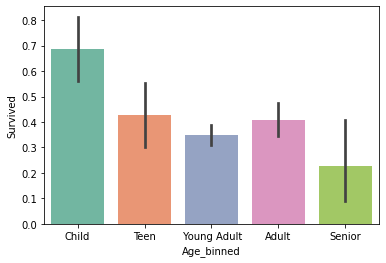

In [ ]:
# Children indeed had a much better chance of surviving
sns.barplot(x="Age_binned", y = "Survived", data = engineered, palette = 'Set2')
ax.set(title = "Survival Rate by Age Group")
plt.show()

I also want to keep Age as a continuous feature. We will check here if the feature is normally distributed. Scaling will happen further on in the notebook.

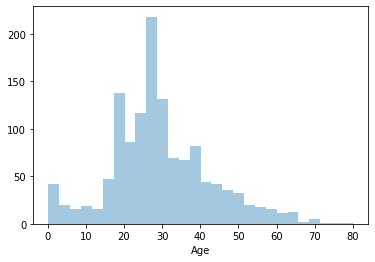

In [ ]:
#Age looks fairly normally distributed
sns.distplot(cleaned["Age"], kde=False)

In [ ]:
#check skewness: Age is not normally distributed, but it isn't too far off.
cleaned["Age"].skew()

0.4818022725950596

**3.1.2 FARE**

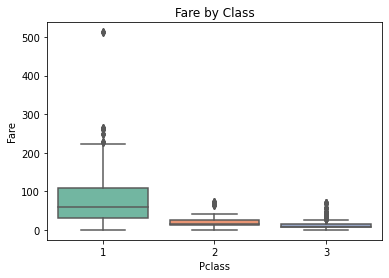

In [ ]:
# The fare differs greatly between classes. Within first class there is also great variation.
plt.figure(figsize=(6,4))
ax =sns.boxplot(x= "Pclass", y = "Fare", data = cleaned , palette = 'Set2')
ax.set(title = 'Fare by Class')
plt.show()

In [ ]:
# The fare of different classes overlap. Fare looks like a messy feature.
median = cleaned_train.groupby(["Pclass"])["Fare"].median()
mean = cleaned_train.groupby(["Pclass"])["Fare"].mean()
minimum = cleaned_train.groupby(["Pclass"])["Fare"].min()
maximum = cleaned_train.groupby(["Pclass"])["Fare"].max()
FareClass = pd.concat([minimum, mean, median, maximum], axis=1, keys = ["Min", "Mean", "Median", "Max"])
FareClass

,Min,Mean,Median,Max
Pclass,,,,
1,0.0,84.154687,60.2875,512.3292
2,0.0,20.662183,14.2500,73.5000
3,0.0,13.675550,8.0500,69.5500


In [ ]:
# We will bin the fare in order to make it a little less messy
bins = [-1, 8.05, 14.25, 32, 60, 250, np.inf]

#Bin labels
labels = ["Very Low", "Low", "Average","Above Average", "High", "Very High"]

#bin the Age using the specified boundaries
engineered["Fare_binned"] = pd.cut(cleaned["Fare"], bins, labels = labels)

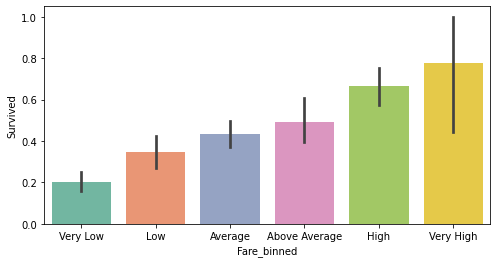

In [ ]:
# We can clearly see that people who paid more, had a better chance of surviving
plt.figure(figsize=(8,4))
sns.barplot(x="Fare_binned", y = "Survived", data = engineered, palette = 'Set2')
ax.set(title = "Survival Rate by Age Group")
plt.show()

I also want to keep Fare as a continuous feature. We will check here if the feature is normally distributed. Scaling will happen further on in the notebook.

4.369596551129241

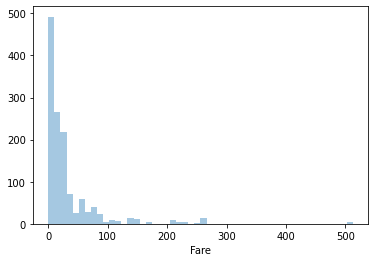

In [ ]:
#Fare is highly skewed
sns.distplot(cleaned["Fare"], kde=False)
cleaned["Fare"].skew()

In [ ]:
#Log normalizing Fare makes the feature a lot less skewed
engineered["FareLog"] =np.log(cleaned["Fare"]+1)

0.5413054618808321

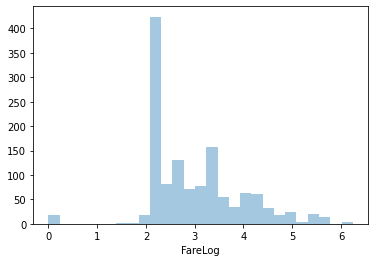

In [ ]:
#FareLog is a lot less skwed
sns.distplot(engineered["FareLog"], kde=False)
engineered["FareLog"].skew()

####**3.2 BINARY FEATURES**

**3.2.1 SEX**

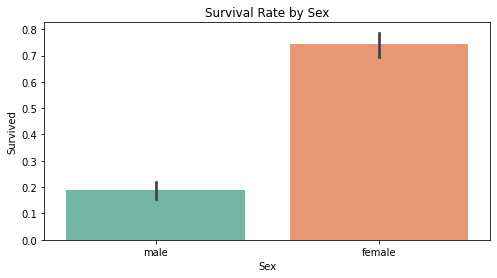

In [ ]:
# Woman had a much better chance of surviving than man
plt.figure(figsize=(8,4))
ax = sns.barplot(x="Sex", y = "Survived", data = cleaned, palette = 'Set2')
ax.set(title = "Survival Rate by Sex")
plt.show()

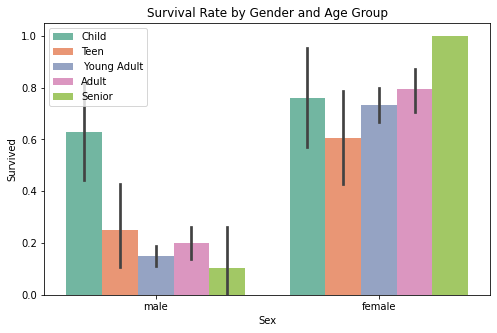

In [ ]:
# Interestingly, woman survive pretty well along all age classes, while men mostly survive when they are young
plt.figure(figsize=(8,5))
ax = sns.barplot(x="Sex", y = "Survived", hue = "Age_binned", data = engineered, palette = 'Set2')
plt.legend(loc= "upper left")
ax.set(title = "Survival Rate by Gender and Age Group")
plt.show()

In [ ]:
#convert Sex to a numerical feature
engineered["Sex"] = cleaned["Sex"].apply(lambda x: 1 if x =="male" else 0)

####**3.3 DISCRETE FEATURES**

**3.3.1 Class**

In [ ]:
# Relatively much more passengers survived in first class
Class = pd.pivot_table(cleaned, index = "Survived", columns = "Pclass", values = "PassengerId", aggfunc= "count")
Class.head()

Pclass,1,2,3
Survived,,,
0.0,80,97,372
1.0,136,87,119


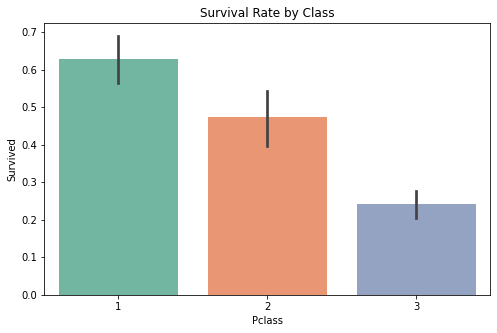

In [ ]:
# We can confirm the lower survival of third class passengers with a barplot
plt.figure(figsize=(8,5))
ax = sns.barplot(x="Pclass", y = "Survived",  data = engineered, palette = 'Set2')
ax.set(title = "Survival Rate by Class")
plt.show()

**3.3.2 SIBSP & PARCH**

SibSp indicates the number of siblings and spouses aboard the Titanic. Parch indicates the number of children or parents aboard. In earlier versions of the notebook I used the sum of these two features to indicate the group size a person was travelling with. However, this feature turned out to be a poor representation of the actual group size, because it doesn't include cousins, nannies, friends etc. Further on in this notebook we will create a better feature to figure out who is travelling with whom. 

####**3.4 NOMINAL FEATURES**

**3.4.1 TITLE**

In [ ]:
#It looks like a lot of people with the title "Mr" died while a lot of "Mrs", "Miss" and "Master" died.
title = pd.pivot_table(cleaned, index = "Survived", columns = "Title", values = "PassengerId", aggfunc= "count")
title

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0.0,1.0,1.0,NaN,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN
1.0,NaN,1.0,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0


It is pretty important that people (especially men) in the most common title groups have the correct title. I noticed that the oldest boy with the title "Master" was 40, and the youngest "Mr" was 1. We will have to correct these titles.

In [ ]:
#check the median and mean Fare per class and title (only of training data to avoid leakage)
mini = engineered.groupby([ "Title"])["Age"].min()
maxi = engineered.groupby([ "Title"])["Age"].max()
mean = engineered.groupby([ "Title"])["Age"].mean()
age = pd.concat([mini, mean, maxi], axis=1, keys = ["min", "avg", "max"])
age

,min,avg,max
Title,,,
Capt,70,70.000000,70
Col,47,54.000000,60
Countess,33,33.000000,33
Don,40,40.000000,40
Dona,39,39.000000,39
Dr,23,43.875000,54
Jonkheer,38,38.000000,38
Lady,48,48.000000,48
Major,45,48.500000,52


In [ ]:
#Correct the title of adult men that where labeled as  "Master"
mask = (engineered["Title"] == "Master") & (engineered["Age"]>17)
wrong_title = engineered.loc[mask]
engineered.loc[mask, "Title"] = "Mr"

In [ ]:
#Correct the title of boys that where labeled as "Mr"
mask = (engineered["Title"] == "Mr") & (engineered["Age"]<18)
engineered.loc[mask, "Title"] = "Master"

In [ ]:
# replacing some titles and grouping them in main categories
engineered['Title'] = engineered['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Ms'], 'Other')
engineered['Title'] = engineered['Title'].replace('Mlle', 'Miss')
engineered['Title'] = engineered['Title'].replace('Mme', 'Mrs')


**3.4.2 SURNAME**

I spend a lot of time on the Surname feature. My hypothesis was that non-native speakers were more likely to die, because they wouldn't be able to understand the crews instructions. I compiled a list of thousands of common English and Irish surnames and found..... NOTHING!!! 


After doing some research, I found that a lot of Irish people travelled in third class, and perished. Many American passengers lived, while many British passengers died. 

In [ ]:
# we can easily get the surnames by splitting the dataset at the comma and grabbing the first value. I won't use this feature here.
engineered["Surname"]= cleaned["Name"].str.split(",").str.get(0)

**3.4.3 TICKET**

I thought it would be interesting to figure out who was travelling with whom. 


I found out that there is no easy way to identify groups. If you look at surnames, you will misidentify people who share the same name, but don't travel together. You will also miss people who travel together but have different surnames. If you look at the ticket number, you will include people who travel together but have different surnames, but miss people whose ticket is one number off. 

You have no way of knowing for sure who is travelling together. For example, The Anderssons travel together in a group of 3 on the same ticket number. Lundahl travels alone, but his ticket number is one number of from the Anderssons. Is this a coincidence? Or is Lundahl a friend or cousin of the Anderssons? 

After checking a lot of tickets and surnames, I felt that ticket number would be the best way to identify people travelling together.  That is, until I found a better way of identifying groups.



In [ ]:
#This is how I extracted ticket numbers. I won't actually use this feature here.
#extract TicketNumber: if Ticket number is "LINE", replace by 0
engineered["TicketNr"] = engineered["Ticket"].str.split(" ").str.get(-1)
engineered["TicketNr"]  = engineered["TicketNr"] .replace("LINE",0)
engineered.TicketNr[engineered.TicketNr == 0] = np.nan

**3.4.4 GROUPS**

Before I was able to properly identify groups, I scored a 78.9% accuracy on Kaggle, a top 12% score. Not bad at all! After researching on how I could improve my score, I came across the kernel of [David Silva](https://www.kaggle.com/dr1t10/surviving-the-titanic-step-by-step-with-groups). Based on several other high scoring kernels, he identifies groups based on a combination of surname, ticket, port and class. I used his code to build a few new features.

In [ ]:
#define groups using surname, ticket (minus the last digit), class and port. 
surname = engineered['Name'].apply(lambda x: x[:x.find(',')])
ticket = engineered['Ticket'].apply(lambda x: x[:-1])

engineered['SPTE'] = (surname.astype(str) + '-' + engineered['Pclass'].astype(str) + '-'
           + ticket.astype(str) + '-' + engineered['Embarked'].astype(str))

spte_count = engineered['SPTE'].value_counts(sort=False)

def spte_group_labeller(group):
    group_elements = engineered.loc[engineered['SPTE'] == group, 'PassengerId']
    if len(group_elements) == 1:
        return 0
    else:
        return group_elements.min()

engineered['GroupId'] = engineered['SPTE'].apply(spte_group_labeller)
#engineered.drop(columns='SPTE', inplace=True)
engineered.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_binned,Fare_binned,Surname,TicketNr,GroupId,GroupSize,SPTE
413,1305,NaN,3,"Spector, Mr. Woolf",1,31,0,0,A.5. 3236,8.0500,U,S,Mr,Young Adult,Very Low,Spector,3236,0,748,Spector-3-A.5. 323-S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39,0,0,PC 17758,108.9000,C105,C,Other,Adult,High,Oliva y Ocana,17758,0,3,Oliva y Ocana-1-PC 1775-C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38,0,0,SOTON/O.Q. 3101262,7.2500,U,S,Mr,Adult,Very Low,Saether,3101262,0,748,Saether-3-SOTON/O.Q. 310126-S
416,1308,NaN,3,"Ware, Mr. Frederick",1,32,0,0,359309,8.0500,U,S,Mr,Young Adult,Very Low,Ware,359309,0,748,Ware-3-35930-S
417,1309,NaN,3,"Peter, Master. Michael J",1,24,1,1,2668,22.3583,U,C,Master,Young Adult,Average,Peter,2668,129,3,Peter-3-266-C


In [ ]:
#we can identify 199 different groups
engineered['GroupId'].nunique()

199

**3.4.5 GROUP SIZE**

In [ ]:
#We can identify the groupsize of each GroupId by counting the passengerId's for each group
engineered["GroupSize"] = engineered.groupby("GroupId")["PassengerId"].transform('count')

In [ ]:
#Most first class passengers boarded in Southampton
ax = sns.countplot(x="Pclass", hue="Embarked", data=raw, palette = 'Set2')
ax.set(title = "Embarkation port by Class")
plt.show()

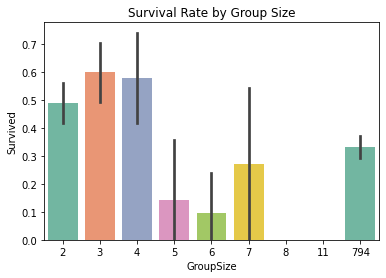

In [ ]:
#People who travelled alone (code 748) or in groups of 5 or more had a much lower chance of survival
ax = sns.barplot(x="GroupSize", y = "Survived", data = engineered, palette = "Set2")
ax.set(title = "Survival Rate by Group Size")
plt.show()

**3.4.6 COMPANY**

In [ ]:
#create feature Company
engineered["Company"] = engineered["GroupSize"].apply(lambda x: "Alone" if x == 794 else "Pair" if x == 2 else "Small Group" if x <5 else "Large Group")

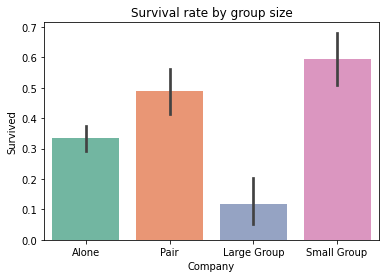

In [ ]:
#People who travelled in a small group or in a pair had a higher chance of surviving
ax =sns.barplot(x="Company", y = "Survived", data = engineered, palette = "Set2")
ax.set(title = "Survival rate by group size")
plt.show()

**3.4.7 IN GROUP**

In [ ]:
#Is the passenger travelling in a group or not
engineered["InGroup"] = engineered["GroupId"].apply(lambda x: 1 if x >0 else 0)

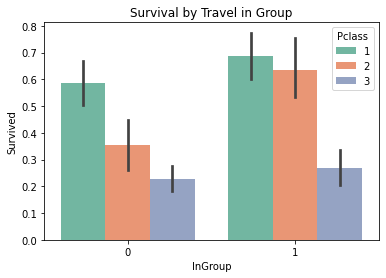

In [ ]:
#travelling in a group increases the chance of survival in all classes
ax = sns.barplot(x="InGroup", y = "Survived", hue = "Pclass" , data = engineered, palette = "Set2")
ax.set(title = 'Survival by Travel in Group')
plt.show()

**3.4.8 WOMAND CHILD GROUPS**

[Chris Deotte](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210) noticed how nearly all  80 woman-child-groups either all lived or all died (based on the survival information we know). That is the secret behind the woman-child-group model. Identifying women-child groups is therefore interesting. Credits to [David Silva](https://www.kaggle.com/dr1t10/surviving-the-titanic-step-by-step-with-groups) for the code. Chris and David also experiment with creating features that indicate whether all people in a Woman Child Group live or die. This could be interesting to explore some time in the future.

In [ ]:
# Create a mask to filter out groups (i.e. people not travelling alone) containing woman and children
mask = (engineered["Company"] != "Alone") & ((engineered["Sex"]== 0) | (engineered["Title"] == "Master"))

# Count the number of woman and children (mask) for each GroupId (set GroupId as index); Get rid of groups with only one woman or child
WomanChildGroups = engineered.loc[mask, 'GroupId'].value_counts()
WomanChildGroups = WomanChildGroups[WomanChildGroups > 1]

# Update the mask to discard groups with only one female or boy
mask = mask & (engineered['GroupId'].isin(WomanChildGroups.index))

# Create the new feature using the updated mask
engineered['WomanChildGroup'] = 0
engineered.loc[mask, 'WomanChildGroup'] = 1

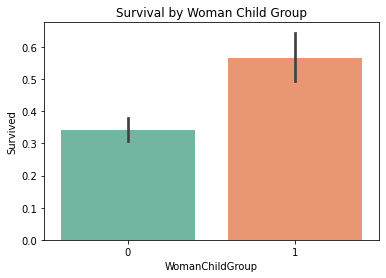

In [ ]:
#people travelling in a woman and child group have a higher chance of survival
ax = sns.barplot(x="WomanChildGroup", y = "Survived" , data = engineered, palette = "Set2")
ax.set(title = 'Survival by Woman Child Group')
plt.show()

####**3.5 ORDINAL FEATURES**

**3.5.1 DECK**

In [ ]:
#extract the Deck from the Cabin feature
engineered["Deck"] = cleaned["Cabin"].str[0]

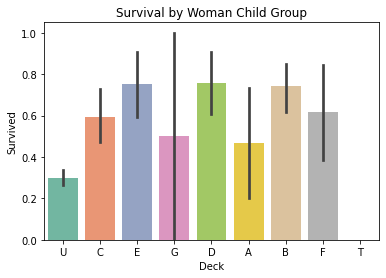

In [ ]:
#People with unknown Deck ID's tend to die, but there is a lot of variation in this feature.
ax = sns.barplot(x="Deck", y = "Survived" ,data = engineered, palette = "Set2")
ax.set(title = 'Survival by Woman Child Group')
plt.show()

In [ ]:
#Passengers with unknown Deck most often travel in third class. 
Deck= pd.pivot_table(engineered, index = "Pclass", columns = "Deck", values = "PassengerId", aggfunc= "count")
Deck

Deck,A,B,C,D,E,F,G,T,U
Pclass,,,,,,,,,
1,22.0,65.0,94.0,40.0,34.0,NaN,NaN,1.0,67.0
2,NaN,NaN,NaN,6.0,4.0,13.0,NaN,NaN,254.0
3,NaN,NaN,NaN,NaN,3.0,8.0,5.0,NaN,693.0


I though Deck would be an ordinal feature, but looking at the survival by deck, it isn't really. Deck is extracted from the Cabin feature. Having a cabin close to a staircase would probably have helped. I will therefore use onehot encoding on this feature.

####**3.6 SCALING & ENCODING**

In [ ]:
engineered.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_binned,Fare_binned,Surname,TicketNr,GroupId,GroupSize,SPTE,Company,InGroup,WomanChildGroup,Deck
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,U,S,Mr,Young Adult,Very Low,Braund,21171,0,794,Braund-3-A/5 2117-S,Alone,0,0,U
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,C,Mrs,Adult,High,Cumings,17599,2,2,Cumings-1-PC 1759-C,Pair,1,0,C


In [ ]:
#there are a few features that we can drop
final = engineered.drop(["Name","SibSp","Fare", "Parch", "Ticket", "Cabin", "Surname", "TicketNr", "SPTE", "GroupId", "GroupSize"],axis=1)
final.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,Title,Age_binned,Fare_binned,Company,InGroup,WomanChildGroup,Deck,FareLog
0,1,0.0,3,1,22,S,Mr,Young Adult,Very Low,Alone,0,0,U,2.110213
1,2,1.0,1,0,38,C,Mrs,Adult,High,Pair,1,0,C,4.280593
2,3,1.0,3,0,26,S,Miss,Young Adult,Very Low,Alone,0,0,U,2.188856
3,4,1.0,1,0,35,S,Mrs,Young Adult,Above Average,Pair,1,0,C,3.990834
4,5,0.0,3,1,35,S,Mr,Young Adult,Very Low,Alone,0,0,U,2.202765


**3.6.1 SCALING**

In [ ]:
#split data in train and test
final_train = final[final["PassengerId"].isin(train["PassengerId"])]
final_test =  final[final["PassengerId"].isin(test["PassengerId"])]

In [ ]:
# Instantiate StandardScaler
SS_scaler = StandardScaler()

#Age
SS_scaler.fit(final_train[['Age']])
final_train['Age_S'] = SS_scaler.transform(final_train[['Age']])
final_test['Age_S'] = SS_scaler.transform(final_test[['Age']])

#Fare
#fit and transform FareLog
SS_scaler.fit(final_train[['FareLog']])
final_train['FareLog_S'] = SS_scaler.transform(final_train[['FareLog']])
final_test['FareLog_S'] = SS_scaler.transform(final_test[['FareLog']])

#merg train and test together 
final = pd.concat([final_train, final_test])
final = final.drop(["Age", "FareLog"], axis=1)

**3.6.2 ONE HOT ENCODING**

In [ ]:
#one hot encode Deck
deck = pd.get_dummies(final['Deck'], prefix="Deck")
final = pd.concat([final, deck], axis=1)

#one hot encode Embarked
embarked = pd.get_dummies(final['Embarked'], prefix="Port")
final = pd.concat([final, embarked], axis=1)

#one hot encode Title
title = pd.get_dummies(final['Title'], prefix="Title")
final = pd.concat([final, title], axis=1)

#one hot encode Age binned
title = pd.get_dummies(final['Age_binned'], prefix="Age")
final = pd.concat([final, title], axis=1)

#one hot encode Fare binned
title = pd.get_dummies(final['Fare_binned'], prefix="Fare")
final = pd.concat([final, title], axis=1)

#one hot encode Company
title = pd.get_dummies(final['Company'], prefix="Company")
final = pd.concat([final, title], axis=1)

# drop redundant features and save
to_drop = ["Deck", "Embarked", "Title", "Age_binned", "Fare_binned", "Company"]
final = final.drop(to_drop, axis=1)


In [ ]:
#check final dataframe
final.head()

,PassengerId,Survived,Pclass,Sex,InGroup,WomanChildGroup,Age_S,FareLog_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Port_C,Port_Q,Port_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Age_Child,Age_Teen,Age_ Young Adult,Age_Adult,Age_Senior,Fare_Very Low,Fare_Low,Fare_Average,Fare_Above Average,Fare_High,Fare_Very High,Company_Alone,Company_Large Group,Company_Pair,Company_Small Group
0,1,0.0,3,1,0,0,-0.528023,-0.879741,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
1,2,1.0,1,0,1,0,0.657596,1.361220,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,3,1.0,3,0,0,0,-0.231618,-0.798540,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
3,4,1.0,1,0,1,0,0.435293,1.062038,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
4,5,0.0,3,1,0,0,0.435293,-0.784179,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0


##**4 MODELLING**

I made a total of 28 submissions to Kaggle. This Random Forest achieved the highest accuracy score on the Public Leaderboard. Overfitting is what most people struggle with in this particular dataset. I kept the maximum depth of the Random Forest relatively low, to reduce the effect of overfitting.

In [ ]:
#split in train and test
#final_train = final[final["PassengerId"].isin(train["PassengerId"])]
#final_test =  final[final["PassengerId"].isin(test["PassengerId"])]

In [ ]:
#create train-test-split Full dataframe
#X1 = final_train.drop(["PassengerId", "Survived"], axis=1)
#y1 = final_train["Survived"]

#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state=42)


In [ ]:
#random_state = 4
#model = RandomForestClassifier(random_state=4)
#parameters = {"n_estimators": [50,100,300,500],
              "max_depth": [2,4,5]}


#kfold = KFold(n_splits= 3, random_state=random_state, shuffle = True)

#cv = GridSearchCV(model, param_grid = parameters, cv=kfold, scoring = "accuracy")

# Fit cv to the training set: 
#cv.fit(X1_train, y1_train)

# Predict on test set
#y1_pred = cv.predict(X1_test)
#y1_pred_proba = cv.predict_proba(X1_test)[:,1]


# Compute and print accuracy
#print("Accuracy train: {}".format(cv.score(X1_train, y1_train)))
#print("Accuracy test: {}".format(cv.score(X1_test, y1_test)))
#print("AUC score: {}".format(roc_auc_score(y1_test, y1_pred_proba)))
#print("Tuned Model Parameters: {}".format(cv.best_params_))
#print(confusion_matrix(y1_test, y1_pred))
#print(classification_report(y1_test, y1_pred))



Accuracy train: 0.8539325842696629
Accuracy test: 0.8268156424581006
AUC score: 0.8889961389961388
Tuned Model Parameters: {'max_depth': 5, 'n_estimators': 50}
[[92 13]
 [18 56]]
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       105
         1.0       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Text(0.5, 0, 'Relative Importance')

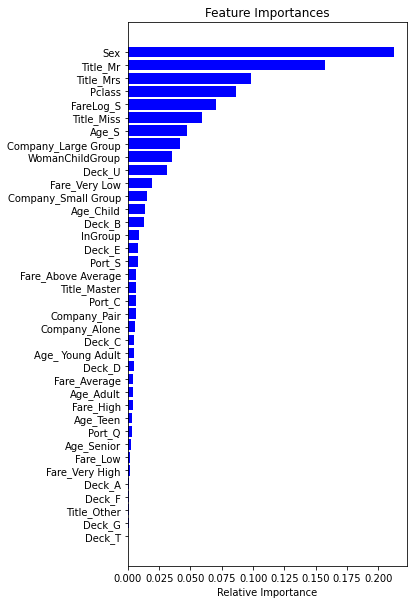

In [ ]:

#features= X1_train.columns
#importances = cv.best_estimator_.feature_importances_
#indices = np.argsort(importances)

#fig, ax = plt.subplots(figsize=(5,10)) 
#plt.figure(1)
#plt.title('Feature Importances')
#plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), features[indices])
#plt.xlabel('Relative Importance')

In [ ]:
# make predictions on test data
#final_test ["Survived"] = cv.predict(final_test.drop(["PassengerId", "Survived"], axis=1))
#final_test ["Survived"] = final_test ["Survived"].astype("int")


# save the submission in the right format
#final_test[["PassengerId", "Survived"]].to_csv('kaggle_sumbission_F1.csv', index=False)

##**5 CONCLUSION**


**ACCURACY**

My testing accuracy was 82.7% and my accuracy on the public leaderboard was 79.2%. In comparison to many of my other models, this model didn't overfit too much.

I correctly predicted 92 passengers who didn't survive and 56 passengers who did survive. I had 18 false negatives (I predicted these passengers would survive, but they didn't) and 13 false positives (I predicted that the passenger would live, but they died). 

Looking at the confusion matrix and classification report, my model seems to be better at predicting who died than who lived. Much more people died than lived, so this isn't too strange. Any feature that could help predict what characteristics helped you survive will probably improve the model.


**FEATURE IMPORTANCE**

The feature importance graph indicates that the following features contributed most to the decision making process. 


1.   Gender
2.   Mr Title (adult male)
3.   Mrs Title (female passenger of any age)
4.   Class
5.   Fare (log transformed)
6.   Title Miss (unmarried woman, but in practice females of any age)
7.   Age (scaled)
8.   Travelling in Large groups (5 or more persons)
9.   Travelling in Woman Child group (group with >1 woman or children)
10.  Having an unknown deck (often third class Passenger)


**FUTURE IMPROVEMENTS**

It is clear that gender, age, class and travel company are important factors in the decision-making process. Age is a feature with a lot of missing values, so the better you can impute these values, the better the model is. Looking at Mice or KNN imputing could be an interesting idea. A lot of people have mislabeled titles, fixing these might improve the model further. Correctly identifying who is travelling with whom is also a challenge that could improve the peformance of the model. And then of course there is hyperparameter tuning (although in my case this often resulted in a lower score on the public leaderboard) and stacking different models together.


**CONCLUDING REMARK**

Although the Titanic sank over 100 years ago, it still captivates many people, including many data scientists. New features and models still appear very regularly. Pretty fascinating stuff! 